In [1]:
import numpy as np
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import theano
import pymc3 as pm
import lasagne
import theano.tensor as T

floatX = theano.config.floatX

Using cuDNN version 5005 on context None
Mapped name None to device cuda: GRID K520 (0000:00:03.0)


In [3]:
import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
from sklearn.metrics import accuracy_score

In [74]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    mnist = fetch_mldata('MNIST original')
    data = mnist['data'].reshape((70000, 1, 28, 28)).astype(np.float32)
    target = mnist['target'].astype(np.float32)
    # We can now download and read the training and test set images and labels.
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=10000)
    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print("Finished!")

Loading data...
Finished!


In [75]:
input_shape = list(X_train.shape)
input_shape[0] = None
input_shape = tuple(input_shape)
input_shape

(None, 1, 28, 28)

In [76]:
class PriorWeights(object):
    def __init__(self, mode='W', prior='gauss', **params):
        self.count = 0
        self.prior = prior
        self.mode = mode
        params.setdefault('std', 1.)
        params.setdefault('hyper', None)
        self.params = params
    def __call__(self, shape):
        self.count += 1
        if self.params['hyper'] is None:
            std = self.params['std']
        elif self.params['hyper'] == 'cauchy':
            std = pm.HalfCauchy('hyper_%s%d' % (self.mode, self.count), beta=1.)
        elif self.params['hyper'] == 'normal':
            std = pm.HalfNormal('hyper_%s%d' % (self.mode, self.count), mu=0., sd=1.)
        elif self.params['hyper'] == 'flat':
            std = pm.Flat()
        if self.prior == 'gauss':
            return pm.Normal('%s%d' % (self.mode, self.count), mu=0, sd=std, 
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)
        elif self.prior == 'laplace': 
            return pm.Laplace('%s%d' % (self.mode, self.count), mu=0, b=std, 
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)
        elif self.prior == 'flat':
            return pm.Flat('%s%d' % (self.mode, self.count), 
                           testval=np.random.normal(size=shape).astype(np.float64), 
                           shape=shape)

In [77]:
def build_ann(prior_b, prior_W, input_var, target_var, 
              input_shape, params=[176, 64]):
    
    n_hid1, n_hid2 = params
    with pm.Model() as neural_network:
        l_in = lasagne.layers.InputLayer(shape=input_shape,
                                         input_var=input_var)
        l_conv1 = lasagne.layers.Conv2DLayer(
                            l_in, num_filters=32, filter_size=(5, 5),
                            b=prior_b, W=prior_W,
                            nonlinearity=lasagne.nonlinearities.tanh)
        
        l_pool1 = lasagne.layers.MaxPool2DLayer(l_conv1, pool_size=(2, 2))
        
        l_conv2 = lasagne.layers.Conv2DLayer(
                            l_pool1, num_filters=32, filter_size=(5, 5),
                            b=prior_b, W=prior_W,
                            nonlinearity=lasagne.nonlinearities.tanh)

        l_pool2 = lasagne.layers.MaxPool2DLayer(l_conv2, pool_size=(2, 2))

        l_dense1 = lasagne.layers.DenseLayer(
                            l_pool2, num_units=n_hid1,
                            b=prior_b, W=prior_W,
                            nonlinearity=lasagne.nonlinearities.tanh)

        l_dense2 = lasagne.layers.DenseLayer(
                            l_dense1, num_units=n_hid2,
                            b=prior_b, W=prior_W,
                            nonlinearity=lasagne.nonlinearities.tanh)

        l_out = lasagne.layers.DenseLayer(
                            l_dense2, num_units=10,
                            b=prior_b, W=prior_W,
                            nonlinearity=lasagne.nonlinearities.softmax,
        )

        prediction = lasagne.layers.get_output(l_out)
        
        out = pm.Categorical('out', prediction,
                           observed=target_var,
                           total_size=y_train.shape[0])
    
    return neural_network

In [78]:
def create_minibatch(data):
    rng = np.random.RandomState(0)
    
    while True:
        ixs = rng.randint(len(data), size=100)
        yield data[ixs]

In [79]:
def get_prediction(samples_proba):
    return mode(np.argmax(sample_proba(X_test, 500), 
                          axis=-1), axis=0).mode[0]

In [80]:
minibatch_X = pm.generator(create_minibatch(X_train))
minibatch_y = pm.generator(create_minibatch(y_train))
neural_network_minibatch = build_ann(PriorWeights(mode='b', prior='flat'), 
                                     PriorWeights(mode='W', prior='gauss'),
                                     minibatch_X, minibatch_y, 
                                     input_shape, params=[176, 64])

In [81]:
ADVI_ITERS = 50000
N_SAMPLES = 500

In [82]:
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(ADVI_ITERS, method=inference)

Average Loss = 76,636: 100%|██████████| 50000/50000 [06:09<00:00, 135.34it/s]


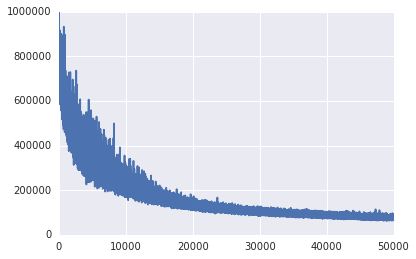

In [83]:
plt.plot(inference.hist[10:])

In [88]:
x = T.tensor4('X')
n = T.iscalar('n')
theano.config.compute_test_value = 'off'
_sample_proba = approx.sample_node(neural_network_minibatch.out.distribution.p, 
                                   size=n,
                                   more_replacements={minibatch_X:x})
prediction = approx.apply_replacements(neural_network_minibatch.out.distribution.p, 
                                    deterministic=True, 
                                    more_replacements={minibatch_X:x})

sample_proba = theano.function([x, n], _sample_proba)
map_proba = theano.function([x], prediction)

In [93]:
y_pred_MAP = np.argmax(map_proba(X_test), axis=1)
error_under_MAP = y_pred_MAP != y_test
error_rate_under_MAP = error_under_MAP.mean()

y_preds_posterior = sample_proba(X_test, 100)
y_pred_posterior = mode(np.argmax(y_preds_posterior, axis=-1), axis=0).mode[0]
error_under_posterior = y_pred_posterior != y_test
error_rate_under_posterior = error_under_posterior.mean()

In [94]:
print('MAP                      : %f' % error_rate_under_MAP)
print('predictive posterior mode: %f' % error_rate_under_posterior)

MAP                      : 0.099600
predictive posterior mode: 0.080400


In [96]:
def check_the_error_at(idx):
    print('true:', y_test[error_under_posterior][idx],'prediction:', y_pred_posterior[error_under_posterior][idx])
    plt.gray()
    plt.matshow(X_test[error_under_posterior][idx][0])
    plt.show()

('true:', 3.0, 'prediction:', 5)


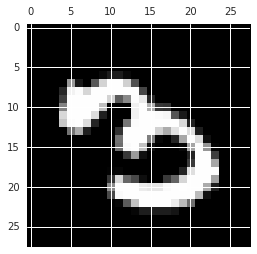

In [97]:
check_the_error_at(0)

('true:', 4.0, 'prediction:', 9)


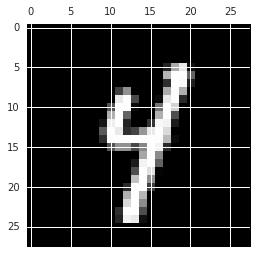

In [98]:
check_the_error_at(1)

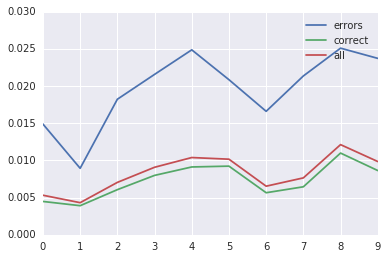

In [99]:
plt.plot(y_preds_posterior.var(0)[error_under_posterior].mean(0), label='errors')
plt.plot(y_preds_posterior.var(0)[~error_under_posterior].mean(0), label='correct')
plt.plot(y_preds_posterior.var(0).mean(0), label='all')
plt.legend()

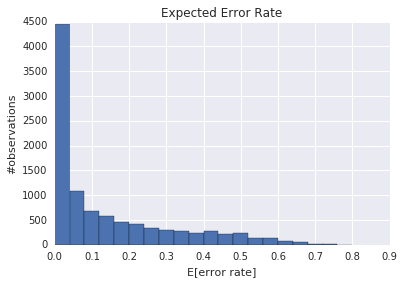

In [100]:
y_preds_labels = np.argmax(y_preds_posterior, axis=-1)
prediction_expected_error_rate = (y_preds_labels != y_pred_posterior).mean(0)
plt.hist(prediction_expected_error_rate, bins=20)
plt.title('Expected Error Rate');
plt.xlabel('E[error rate]')
plt.ylabel('#observations')

In [101]:
((prediction_expected_error_rate != 0) == error_under_posterior).mean()

0.31869999999999998

In [102]:
(prediction_expected_error_rate[error_under_posterior] == 0).mean()

0.0037313432835820895

In [103]:
(prediction_expected_error_rate[error_under_posterior] == 0).sum()

3

In [104]:
houston_we_have_a_problem = prediction_expected_error_rate[error_under_posterior] == 0

In [105]:
def problem_display():
    for i in range(houston_we_have_a_problem.sum()):
        print('true:', y_test[error_under_posterior][houston_we_have_a_problem][i],
              'prediction:', y_pred_posterior[error_under_posterior][houston_we_have_a_problem][i])
        plt.gray();plt.matshow(X_test[error_under_posterior][houston_we_have_a_problem][i][0]);plt.show();

('true:', 1.0, 'prediction:', 2)


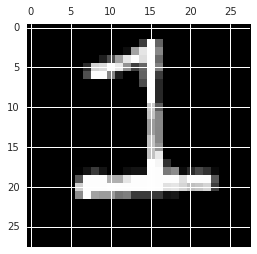

('true:', 7.0, 'prediction:', 0)


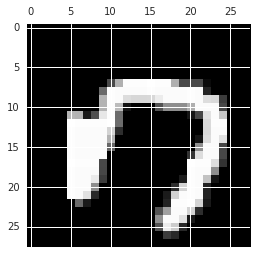

('true:', 2.0, 'prediction:', 7)


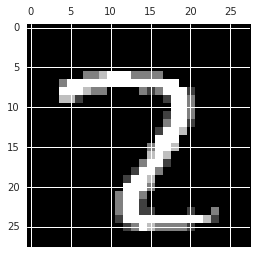

In [106]:
problem_display()

In [108]:
top_three = np.argsort(prediction_expected_error_rate)[-3:][::-1]
top_three

array([6528, 9385,  257])

In [109]:
def low_confidence_examples_display():
    for i in top_three:
        print('true:', y_test[i],
              'prediction:', y_pred_posterior[i],
              'expected error rate:', prediction_expected_error_rate[i]
             )
        plt.gray();plt.matshow(X_test[i][0]);plt.show();

('true:', 2.0, 'prediction:', 5, 'expected error rate:', 0.80000000000000004)


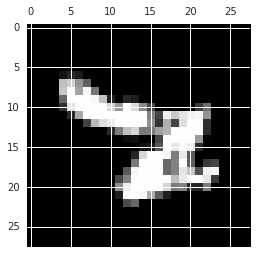

('true:', 0.0, 'prediction:', 2, 'expected error rate:', 0.78000000000000003)


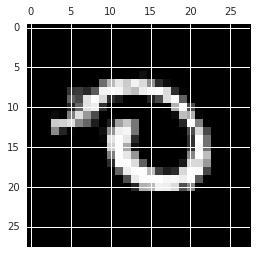

('true:', 0.0, 'prediction:', 4, 'expected error rate:', 0.77000000000000002)


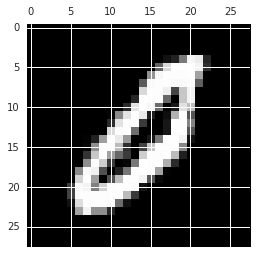

In [110]:
low_confidence_examples_display()